This notebook investigates the NCAR CESM1 model that is provided on AWS cloud 

### Import Packages 

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import intake 
import pprint

### Look at intake-esm catalog for CESM1 model

In [2]:
cat_url = "https://raw.githubusercontent.com/NCAR/cesm-lens-aws/main/intake-catalogs/aws-cesm1-le.json"
col = intake.open_esm_datastore(cat_url)
col

,unique
variable,78
long_name,75
component,5
experiment,4
frequency,6
vertical_levels,3
spatial_domain,5
units,25
start_time,12
end_time,13


In [3]:
col.df

,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,FLNS,net longwave flux at surface,atm,20C,daily,1.0,global,W/m2,1920-01-01 12:00:00,2005-12-31 12:00:00,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-FLNS....
1,FLNSC,clearsky net longwave flux at surface,atm,20C,daily,1.0,global,W/m2,1920-01-01 12:00:00,2005-12-31 12:00:00,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-FLNSC...
2,FLUT,upwelling longwave flux at top of model,atm,20C,daily,1.0,global,W/m2,1920-01-01 12:00:00,2005-12-31 12:00:00,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-FLUT....
3,FSNS,net solar flux at surface,atm,20C,daily,1.0,global,W/m2,1920-01-01 12:00:00,2005-12-31 12:00:00,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-FSNS....
4,FSNSC,clearsky net solar flux at surface,atm,20C,daily,1.0,global,W/m2,1920-01-01 12:00:00,2005-12-31 12:00:00,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-FSNSC...
...,...,...,...,...,...,...,...,...,...,...,...
437,WVEL,vertical velocity,ocn,RCP85,monthly,60.0,global_ocean,centimeter/s,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-W...
438,NaN,NaN,ocn,CTRL,static,NaN,global_ocean,NaN,NaN,NaN,s3://ncar-cesm-lens/ocn/static/grid.zarr
439,NaN,NaN,ocn,HIST,static,NaN,global_ocean,NaN,NaN,NaN,s3://ncar-cesm-lens/ocn/static/grid.zarr
440,NaN,NaN,ocn,RCP85,static,NaN,global_ocean,NaN,NaN,NaN,s3://ncar-cesm-lens/ocn/static/grid.zarr


possible variables of interest for monthly data for RCP 8.5: T = temperature [K], TREFHT = reference height temperature [K], PRECC = convective precipitation rate (liq + ice) [m/s], PRECL = large-scale (stable) precip rate (liq + ice), they also have snow rates. Daily data has PRECT = total (convective + large-scale) precip rate (liq + ice) 

### Filter the catalog for the variables we want 

In [7]:
# Define a query to search the catalog with 
query = dict(
    variable=['PRECC','PRECL'],
    experiment=['RCP85','20C'],
    frequency=['monthly']
)

In [8]:
col_subset = col.search(**query)
col_subset

,unique
variable,2
long_name,2
component,1
experiment,2
frequency,1
vertical_levels,1
spatial_domain,1
units,1
start_time,2
end_time,2


In [9]:
col_subset.df

,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,PRECC,convective precipitation rate (liq + ice),atm,20C,monthly,1.0,global,m/s,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/atm/monthly/cesmLE-20C-PRE...
1,PRECL,large-scale (stable) precipitation rate (liq +...,atm,20C,monthly,1.0,global,m/s,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/atm/monthly/cesmLE-20C-PRE...
2,PRECC,convective precipitation rate (liq + ice),atm,RCP85,monthly,1.0,global,m/s,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/atm/monthly/cesmLE-RCP85-P...
3,PRECL,large-scale (stable) precipitation rate (liq +...,atm,RCP85,monthly,1.0,global,m/s,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/atm/monthly/cesmLE-RCP85-P...


Q: In Lehner et al., how do they get precip in % ? Will we need to do this? And which precip variable should we use? I guess it would make sense to check them all out. Are extreme precip events associated with convection, large-scale, or both? 

### Lets start with investigating reference height temperature
Doing reference height temp so I dont have to deal with lev dimension. Is this the variable we would want to use? Could we use T variable and average over lev? 

In [7]:
# Define a query for temperature 
T_query = dict(
    variable=['TREFHT'],
    experiment=['RCP85'],
    frequency=['monthly']
)

In [8]:
# create a catalog for the temp variable only and view the catalog 
T_col = col.search(**T_query)
T_col.df

,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,TREFHT,reference height temperature,atm,RCP85,monthly,1.0,global,K,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/atm/monthly/cesmLE-RCP85-T...


In [10]:
# load data into xarray datasets
dset = col_subset.to_dataset_dict(zarr_kwargs={'consolidated':True}, storage_options={"anon": True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'


In [14]:
future = dset['atm.RCP85.monthly']

In [15]:
hist = dset['atm.20C.monthly']

In [16]:
hist

<xarray.Dataset>
Dimensions:    (member_id: 40, time: 1032, lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) int64 1 2 3 4 5 6 7 8 ... 34 35 101 102 103 104 105
  * time       (time) object 1920-01-16 12:00:00 ... 2005-12-16 12:00:00
    time_bnds  (time, nbnd) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
Dimensions without coordinates: nbnd
Data variables:
    PRECC      (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 576, 192, 288), meta=np.ndarray>
    PRECL      (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 576, 192, 288), meta=np.ndarray>
Attributes: (12/13)
    Version:                   $Name$
    title:                     UNSET
    important_note:            This data is part of the project 'Blind Evalua...
    source:                    CAM
    revision_Id:               $Id$
    nco_openmp_thread_number:  1
    ...                        ...
    NCO:                       4.3.4
    initial_file:              b.e11.B20TRC5CNBDRD.f09_g16.001.cam.i.1920-01-...
    logname:                   mudryk
    intake_esm_varname:        PRECC\nPRECL
    topography_file:           /scratch/p/pjk/mudryk/cesm1_1_2_LENS/inputdata...
    intake_esm_dataset_key:    atm.20C.monthly

In [18]:
hist['pr'] = hist['PRECC'] + hist['PRECL']
future['pr'] = future['PRECC'] + future['PRECL']

In [27]:
hist = hist.sel(lat=41,lon=180,method='nearest')

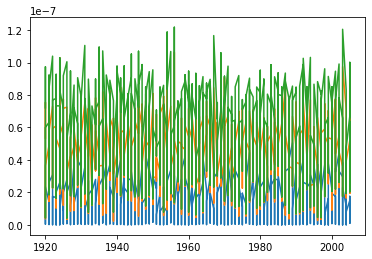

In [30]:
plt.plot(hist.time.dt.year,hist.isel(member_id=0).PRECC)
plt.plot(hist.time.dt.year,hist.isel(member_id=0).PRECL)
plt.plot(hist.time.dt.year,hist.isel(member_id=0).pr)

In [20]:
hist = hist.drop_vars(['PRECC','PRECL'])
hist = hist.drop_vars(['PRECC','PRECL'])

<xarray.Dataset>
Dimensions:    (lat: 192, lon: 288, member_id: 40, time: 1032, nbnd: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) int64 1 2 3 4 5 6 7 8 ... 34 35 101 102 103 104 105
  * time       (time) object 1920-01-16 12:00:00 ... 2005-12-16 12:00:00
    time_bnds  (time, nbnd) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
Dimensions without coordinates: nbnd
Data variables:
    pr         (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 576, 192, 288), meta=np.ndarray>
Attributes: (12/13)
    Version:                   $Name$
    title:                     UNSET
    important_note:            This data is part of the project 'Blind Evalua...
    source:                    CAM
    revision_Id:               $Id$
    nco_openmp_thread_number:  1
    ...                        ...
    NCO:                       4.3.4
    initial_file:              b.e11.B20TRC5CNBDRD.f09_g16.001.cam.i.1920-01-...
    logname:                   mudryk
    intake_esm_varname:        PRECC\nPRECL
    topography_file:           /scratch/p/pjk/mudryk/cesm1_1_2_LENS/inputdata...
    intake_esm_dataset_key:    atm.20C.monthly

In [10]:
# Define temp dataset within dict
temp = dset['atm.RCP85.monthly']

In [47]:
# T variable had 30 levels and ~300 GB data
# T ref height data has no levels and ~ 10 GB
temp

<xarray.Dataset>
Dimensions:    (member_id: 40, time: 1140, lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... -5.0 -3.75 -2.5 -1.25
  * member_id  (member_id) int64 1 2 3 4 5 6 7 8 ... 34 35 101 102 103 104 105
  * time       (time) object 2006-01-16 12:00:00 ... 2100-12-16 12:00:00
    time_bnds  (time, nbnd) object dask.array<chunksize=(1140, 2), meta=np.ndarray>
Dimensions without coordinates: nbnd
Data variables:
    TREFHT     (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 576, 192, 288), meta=np.ndarray>
Attributes: (12/14)
    Conventions:               CF-1.0
    NCO:                       4.3.4
    Version:                   $Name$
    host:                      tcs-f02n07
    important_note:            This data is part of the project 'Blind Evalua...
    initial_file:              b.e11.B20TRC5CNBDRD.f09_g16.105.cam.i.2006-01-...
    ...                        ...
    revision_Id:               $Id$
    source:                    CAM
    title:                     UNSET
    topography_file:           /scratch/p/pjk/mudryk/cesm1_1_2_LENS/inputdata...
    intake_esm_varname:        ['TREFHT']
    intake_esm_dataset_key:    atm.RCP85.monthly

In [48]:
# convert lon from 0-360 to -180 to 180
temp = temp.assign_coords(lon=((temp.lon + 180) % 360 - 180))

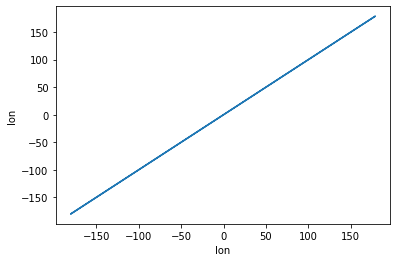

In [49]:
temp.lon.plot()

In [51]:
# convert Kelvin to celcius 
temp['TREFHT'] = temp.TREFHT - 273.15

In [53]:
# resample yearly
temp_yearly = temp.resample(time='Y').mean(dim='time')
# take global average by doing mean of lat/lon
temp_global = temp_yearly.mean(dim=('lon','lat'))
# get global ensemble mean 
temp_ensmean = temp_global.mean(dim=('member_id'))
temp_ensmean

<xarray.Dataset>
Dimensions:  (time: 95)
Coordinates:
  * time     (time) object 2006-12-31 00:00:00 ... 2100-12-31 00:00:00
Data variables:
    TREFHT   (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>

In [54]:
# define local lat/lon
# is there a better way to do this? Is there a way I can provide an estimate 
temp_local = temp_yearly.isel(lon=214,lat=138)

In [55]:
temp_local

<xarray.Dataset>
Dimensions:    (time: 95, member_id: 40)
Coordinates:
  * time       (time) object 2006-12-31 00:00:00 ... 2100-12-31 00:00:00
    lat        float64 40.05
    lon        float64 -92.5
  * member_id  (member_id) int64 1 2 3 4 5 6 7 8 ... 34 35 101 102 103 104 105
Data variables:
    TREFHT     (time, member_id) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>

### Access 20C experiment to get reference data 

In [17]:
# Define a query for reference temperature 
Tref_query = dict(
    variable=['TREFHT'],
    experiment=['20C'],
    frequency=['monthly']
)

In [18]:
# create a catalog for the temp variable only 
Tref_col = col.search(**Tref_query)
# view the catalog
Tref_col.df

,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,TREFHT,reference height temperature,atm,20C,monthly,1.0,global,K,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/atm/monthly/cesmLE-20C-TRE...


In [19]:
# load data into xarray datasets
Tref_dset = Tref_col.to_dataset_dict(zarr_kwargs={'consolidated':True}, storage_options={"anon": True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'


In [56]:
# define temp reference dataset 
temp_ref = Tref_dset['atm.20C.monthly']

In [57]:
# convert lon from 0-360 to -180 to 180
temp_ref = temp_ref.assign_coords(lon=((temp_ref.lon + 180) % 360 - 180))

In [58]:
# convert Kelvin to celcius 
temp_ref['TREFHT'] = temp_ref.TREFHT - 273.15

In [59]:
# slice to base period (note that Lehner et al. uses base period 1995-2014)
# here we have 1920-2005 so I will use 1995-2005 as base period 
temp_ref = temp_ref.sel(time=slice("1995", "2005"))

# resample yearly
temp_ref_yearly = temp_ref.resample(time='Y').mean(dim='time')
# temp_ref_decadal = temp_ref.rolling(time=10,center=True).mean().dropna('time')

# average along lat/lon, time, and member_id to get base temp
temp_ref = temp_ref_yearly.mean(dim=('lon','lat','member_id','time'))
# temp_ref_local = temp_ref_decadal.isel(lon=214,lat=138)
# tem_ref_local = temp_ref_local.mean(dim=('member_id','time'))
temp_ref

<xarray.Dataset>
Dimensions:  ()
Data variables:
    TREFHT   float32 dask.array<chunksize=(), meta=np.ndarray>

In [23]:
temp_ref_decadal = temp_ref_yearly.rolling(time=10,center=True).mean().dropna('time')

In [60]:
# is reference temp also decadal rolling average???
temp_ref_local = temp_ref_yearly.isel(lon=214,lat=138)
temp_ref_local = temp_ref_local.mean(dim=('member_id','time'))

### Calculate anomalies 

In [61]:
# calculate anomalies for ensemble mean 
temp_ensmean_anom = temp_ensmean - temp_ref.TREFHT
temp_ensmean_anom

<xarray.Dataset>
Dimensions:  (time: 95)
Coordinates:
  * time     (time) object 2006-12-31 00:00:00 ... 2100-12-31 00:00:00
Data variables:
    TREFHT   (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>

In [62]:
# index=0
# temp_ensemble_anom = np.zeros(len(temp_global.member_id))
# for index in range(len(temp_global.member_id)):
#     temp_ensemble_anom = temp_global.isel(member_id=index).TREFHT - temp_ref.TREFHT

In [63]:
# calculate anomalies for each ensemble 
temp_ens_anom = temp_global.TREFHT - temp_ref.TREFHT

### Load the data into memory and plot 

In [64]:
temp_ensmean_anom = temp_ensmean_anom.load()

In [65]:
temp_ens_anom = temp_ens_anom.load()

In [66]:
# need to do this to convert cftime format to a useable time for plotting 
temp_ensmean_anom.time.dt.year

<xarray.DataArray 'year' (time: 95)>
array([2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027,
       2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038,
       2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049,
       2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060,
       2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071,
       2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082,
       2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093,
       2094, 2095, 2096, 2097, 2098, 2099, 2100])
Coordinates:
  * time     (time) object 2006-12-31 00:00:00 ... 2100-12-31 00:00:00

In [72]:
temp_global.load()

<xarray.Dataset>
Dimensions:    (time: 95, member_id: 40)
Coordinates:
  * time       (time) object 2006-12-31 00:00:00 ... 2100-12-31 00:00:00
  * member_id  (member_id) int64 1 2 3 4 5 6 7 8 ... 34 35 101 102 103 104 105
Data variables:
    TREFHT     (time, member_id) float32 3.709 4.028 3.633 ... 9.468 9.744 9.523

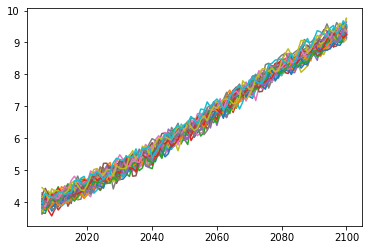

In [74]:
plt.plot(temp_global.time.dt.year,temp_global.TREFHT);

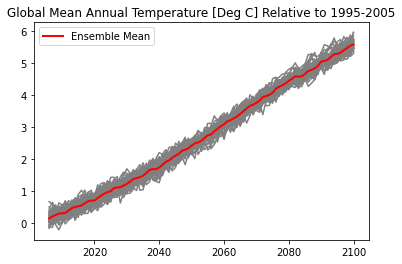

In [104]:
# plot the data 
for i in range(len(temp_ens_anom.member_id)):
    plt.plot(temp_ens_anom.time.dt.year,temp_ens_anom.isel(member_id=i),color='grey')
plt.plot(temp_ensmean_anom.time.dt.year,temp_ensmean_anom.TREFHT,color='r',
         linewidth=2,label='Ensemble Mean')
plt.title('Global Mean Annual Temperature [Deg C] Relative to 1995-2005')
plt.legend()

#### TO-DO:
1. Do the calculation again and account for grid cell areas (cell size varies with lat)
2. Investigate spatial plots before doing the global average 
3. Try to recreate the plots made in this [tutorial](https://github.com/NCAR/cesm-lens-aws/blob/main/notebooks/kay-et-al-2015.v3.ipynb)
4. Start calculating model uncertainity and internal variability as desribed in Lehner et al. 


### Calculate internal variability 
For the CESM1 large ensemble, only internal variability can be estimated. We cannot estimate model uncertainity because we are only working with one model. Internal variability can be calculated in two ways: using the HS09 method or the LE method. The HS09 method fits a fourth order polynomial to each ensemble member and estimates the internal variability as the variance across the fits. For the LE method, the int. variability is calculated as the variance across ensemble members (relative to ensemble mean)

In [75]:
temp_global

<xarray.Dataset>
Dimensions:    (time: 95, member_id: 40)
Coordinates:
  * time       (time) object 2006-12-31 00:00:00 ... 2100-12-31 00:00:00
  * member_id  (member_id) int64 1 2 3 4 5 6 7 8 ... 34 35 101 102 103 104 105
Data variables:
    TREFHT     (time, member_id) float32 3.709 4.028 3.633 ... 9.468 9.744 9.523

In [76]:
temp_global = temp_global.TREFHT

In [77]:
temp_local = temp_local.TREFHT

### start with local data - single point

In [78]:
# take a decadal rolling average and drop times
data = temp_local.rolling(time=10, center=True).mean().dropna('time')

In [79]:
# create X and Y variables for the model fit 
X = np.arange(len(data.time))    # x variable is length of time
Y = data.values  # y is the temp data 

In [80]:
# the polynomial fit (4th order)
Z = np.polyfit(X,Y,4)

In [81]:
# make a copy of the data to do the fit using the coefs from Z 
fit = data.copy()
fit.load()

<xarray.DataArray 'TREFHT' (time: 86, member_id: 40)>
array([[12.25589905, 11.95194855, 12.64551849, ..., 11.69148026,
        12.40105438, 12.4672081 ],
       [12.38414536, 11.9900528 , 12.48436127, ..., 12.07311707,
        12.39466858, 12.54508743],
       [12.45371628, 12.07252502, 12.47600021, ..., 12.43478165,
        12.5973793 , 12.41770935],
       ...,
       [17.24976196, 17.15964203, 17.44832916, ..., 17.50739899,
        18.1035553 , 17.94763184],
       [17.25131683, 17.31751099, 17.36230316, ..., 17.42233276,
        18.14895172, 17.84416199],
       [17.35617523, 17.45581207, 17.51531372, ..., 17.50883331,
        18.10067596, 17.74766846]])
Coordinates:
  * time       (time) object 2011-12-31 00:00:00 ... 2096-12-31 00:00:00
    lat        float64 40.05
    lon        float64 -92.5
  * member_id  (member_id) int64 1 2 3 4 5 6 7 8 ... 34 35 101 102 103 104 105

In [82]:
data.load()

<xarray.DataArray 'TREFHT' (time: 86, member_id: 40)>
array([[12.25589905, 11.95194855, 12.64551849, ..., 11.69148026,
        12.40105438, 12.4672081 ],
       [12.38414536, 11.9900528 , 12.48436127, ..., 12.07311707,
        12.39466858, 12.54508743],
       [12.45371628, 12.07252502, 12.47600021, ..., 12.43478165,
        12.5973793 , 12.41770935],
       ...,
       [17.24976196, 17.15964203, 17.44832916, ..., 17.50739899,
        18.1035553 , 17.94763184],
       [17.25131683, 17.31751099, 17.36230316, ..., 17.42233276,
        18.14895172, 17.84416199],
       [17.35617523, 17.45581207, 17.51531372, ..., 17.50883331,
        18.10067596, 17.74766846]])
Coordinates:
  * time       (time) object 2011-12-31 00:00:00 ... 2096-12-31 00:00:00
    lat        float64 40.05
    lon        float64 -92.5
  * member_id  (member_id) int64 1 2 3 4 5 6 7 8 ... 34 35 101 102 103 104 105

In [83]:
for i, m in enumerate(fit.member_id):
    p = np.poly1d(Z[:,i])
    fit[:, i] = p(X)

In [86]:
temp_ref_local.load()

<xarray.Dataset>
Dimensions:  ()
Coordinates:
    lat      float64 40.05
    lon      float64 -92.5
Data variables:
    TREFHT   float32 11.68

In [87]:
temp_ref = temp_ref_local.TREFHT     # define temp ref variable 
# temp_ref = temp_ref - 273.15    # convert to celcius 
# temp_ref.load()

In [89]:
# calculate anomalies 
data_anom = data - temp_ref
fit_anom = fit - temp_ref 

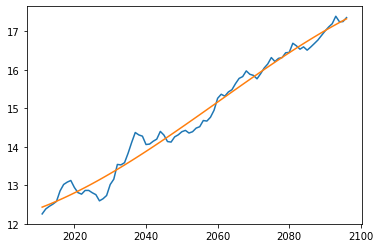

In [84]:
plt.plot(data.time.dt.year,data.isel(member_id=0))
plt.plot(fit.time.dt.year,fit.isel(member_id=0))

Text(0.5, 1.0, '4th Order Poly Fit of CESM (monthly) \n Temperature [Deg C] Projections for (lat,lon)=(40.05,-92.5)')

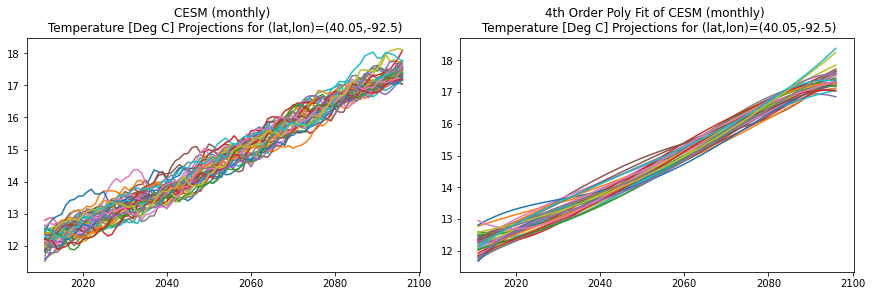

In [103]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True,figsize=(12,4))
for i in range(len(data.member_id)):
    ax[0].plot(data.time.dt.year,data.isel(member_id=i))
    ax[1].plot(fit.time.dt.year,fit.isel(member_id=i))
ax[0].set_title('CESM (monthly) \n Temperature [Deg C] Projections for (lat,lon)=(40.05,-92.5)')
ax[1].set_title('4th Order Poly Fit of CESM (monthly) \n Temperature [Deg C] Projections for (lat,lon)=(40.05,-92.5)')

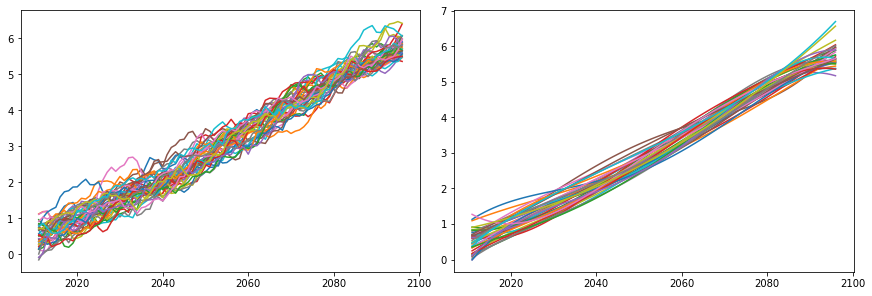

In [90]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True,figsize=(12,4))
for i in range(len(data_anom.member_id)):
    ax[0].plot(data_anom.time.dt.year,data_anom.isel(member_id=i))
    ax[1].plot(fit_anom.time.dt.year,fit_anom.isel(member_id=i))

In [91]:
# calculate internal variability uncertainity
internal = fit.var('member_id')       # this is internal b/c we are dealing with a single model 

Text(0.5, 1.0, 'CESM1-LENS Internal Variability for \n (lat,lon)=(40.05,-92.5) via HS09')

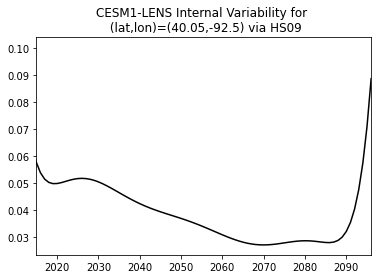

In [102]:
x = internal.time.dt.year
plt.plot(internal.time.dt.year,internal,color='k')
# plt.axhline(internal)
plt.xlim(x[4],x[-1])
plt.title('CESM1-LENS Internal Variability for \n (lat,lon)=(40.05,-92.5) via HS09')

#### calculate internal variability via LE method

In [108]:
data  # data is decadally averaged and sliced for local lat/lon

<xarray.DataArray 'TREFHT' (time: 86, member_id: 40)>
array([[12.25589905, 11.95194855, 12.64551849, ..., 11.69148026,
        12.40105438, 12.4672081 ],
       [12.38414536, 11.9900528 , 12.48436127, ..., 12.07311707,
        12.39466858, 12.54508743],
       [12.45371628, 12.07252502, 12.47600021, ..., 12.43478165,
        12.5973793 , 12.41770935],
       ...,
       [17.24976196, 17.15964203, 17.44832916, ..., 17.50739899,
        18.1035553 , 17.94763184],
       [17.25131683, 17.31751099, 17.36230316, ..., 17.42233276,
        18.14895172, 17.84416199],
       [17.35617523, 17.45581207, 17.51531372, ..., 17.50883331,
        18.10067596, 17.74766846]])
Coordinates:
  * time       (time) object 2011-12-31 00:00:00 ... 2096-12-31 00:00:00
    lat        float64 40.05
    lon        float64 -92.5
  * member_id  (member_id) int64 1 2 3 4 5 6 7 8 ... 34 35 101 102 103 104 105

In [110]:
# "Internal variability uncertainty is calculated as the variance across ensemble members... yielding one estimate per model"
# Am I doing this right? Should I have a fixed value for I? 
internal = data.var('member_id')

Text(0.5, 1.0, 'CESM1-LENS Internal Variability for \n (lat,lon)=(40.05,-92.5) via LE Method')

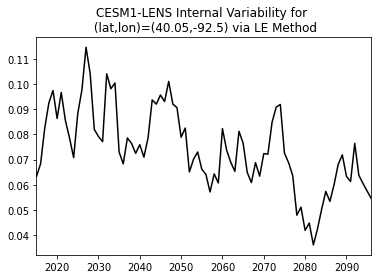

In [112]:
x = internal.time.dt.year
plt.plot(internal.time.dt.year,internal,color='k')
# plt.axhline(internal)
plt.xlim(x[4],x[-1])
plt.title('CESM1-LENS Internal Variability for \n (lat,lon)=(40.05,-92.5) via LE Method')

### Look at global data 

In [113]:
# take a decadal rolling average and drop times
data = temp_global.rolling(time=10, center=True).mean().dropna('time')

In [115]:
data

<xarray.DataArray 'TREFHT' (time: 86, member_id: 40)>
array([[4.1472683, 4.2131457, 4.0952744, ..., 4.1147547, 4.3539796,
        4.2171936],
       [4.232961 , 4.2337494, 4.1417985, ..., 4.1884756, 4.3746834,
        4.287774 ],
       [4.2692184, 4.2699456, 4.2030616, ..., 4.267906 , 4.3908525,
        4.328128 ],
       ...,
       [9.092363 , 8.975054 , 8.937713 , ..., 9.302353 , 9.270027 ,
        9.272532 ],
       [9.1650505, 9.075559 , 9.027014 , ..., 9.346382 , 9.33789  ,
        9.356341 ],
       [9.200039 , 9.129929 , 9.09138  , ..., 9.382886 , 9.414165 ,
        9.397208 ]], dtype=float32)
Coordinates:
  * time       (time) object 2011-12-31 00:00:00 ... 2096-12-31 00:00:00
  * member_id  (member_id) int64 1 2 3 4 5 6 7 8 ... 34 35 101 102 103 104 105

In [116]:
# create X and Y variables for the model fit 
X = np.arange(len(data.time))    # x variable is length of time
Y = data.values  # y is the temp data 

In [117]:
# the polynomial fit (4th order)
Z = np.polyfit(X,Y,4)

In [118]:
Z.shape

(5, 40)

In [119]:
# make a copy of the data to do the fit using the coefs from Z 
fit = data.copy()

In [120]:
fit

<xarray.DataArray 'TREFHT' (time: 86, member_id: 40)>
array([[4.1472683, 4.2131457, 4.0952744, ..., 4.1147547, 4.3539796,
        4.2171936],
       [4.232961 , 4.2337494, 4.1417985, ..., 4.1884756, 4.3746834,
        4.287774 ],
       [4.2692184, 4.2699456, 4.2030616, ..., 4.267906 , 4.3908525,
        4.328128 ],
       ...,
       [9.092363 , 8.975054 , 8.937713 , ..., 9.302353 , 9.270027 ,
        9.272532 ],
       [9.1650505, 9.075559 , 9.027014 , ..., 9.346382 , 9.33789  ,
        9.356341 ],
       [9.200039 , 9.129929 , 9.09138  , ..., 9.382886 , 9.414165 ,
        9.397208 ]], dtype=float32)
Coordinates:
  * time       (time) object 2011-12-31 00:00:00 ... 2096-12-31 00:00:00
  * member_id  (member_id) int64 1 2 3 4 5 6 7 8 ... 34 35 101 102 103 104 105

In [121]:
fit.load()

<xarray.DataArray 'TREFHT' (time: 86, member_id: 40)>
array([[4.1472683, 4.2131457, 4.0952744, ..., 4.1147547, 4.3539796,
        4.2171936],
       [4.232961 , 4.2337494, 4.1417985, ..., 4.1884756, 4.3746834,
        4.287774 ],
       [4.2692184, 4.2699456, 4.2030616, ..., 4.267906 , 4.3908525,
        4.328128 ],
       ...,
       [9.092363 , 8.975054 , 8.937713 , ..., 9.302353 , 9.270027 ,
        9.272532 ],
       [9.1650505, 9.075559 , 9.027014 , ..., 9.346382 , 9.33789  ,
        9.356341 ],
       [9.200039 , 9.129929 , 9.09138  , ..., 9.382886 , 9.414165 ,
        9.397208 ]], dtype=float32)
Coordinates:
  * time       (time) object 2011-12-31 00:00:00 ... 2096-12-31 00:00:00
  * member_id  (member_id) int64 1 2 3 4 5 6 7 8 ... 34 35 101 102 103 104 105

In [122]:
for i, m in enumerate(fit.member_id):
    p = np.poly1d(Z[:,i])
    fit[:, i] = p(X)

In [123]:
data.load()

<xarray.DataArray 'TREFHT' (time: 86, member_id: 40)>
array([[4.1472683, 4.2131457, 4.0952744, ..., 4.1147547, 4.3539796,
        4.2171936],
       [4.232961 , 4.2337494, 4.1417985, ..., 4.1884756, 4.3746834,
        4.287774 ],
       [4.2692184, 4.2699456, 4.2030616, ..., 4.267906 , 4.3908525,
        4.328128 ],
       ...,
       [9.092363 , 8.975054 , 8.937713 , ..., 9.302353 , 9.270027 ,
        9.272532 ],
       [9.1650505, 9.075559 , 9.027014 , ..., 9.346382 , 9.33789  ,
        9.356341 ],
       [9.200039 , 9.129929 , 9.09138  , ..., 9.382886 , 9.414165 ,
        9.397208 ]], dtype=float32)
Coordinates:
  * time       (time) object 2011-12-31 00:00:00 ... 2096-12-31 00:00:00
  * member_id  (member_id) int64 1 2 3 4 5 6 7 8 ... 34 35 101 102 103 104 105

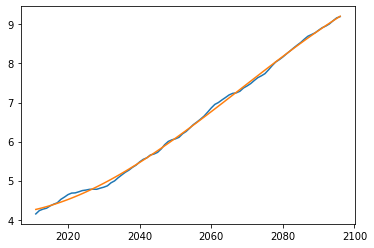

In [124]:
plt.plot(data.time.dt.year,data.isel(member_id=0))
plt.plot(fit.time.dt.year,fit.isel(member_id=0))

Text(0.5, 1.0, '4th Order Poly Fit of CESM (monthly) \n Global Temperature [Deg C] Projections')

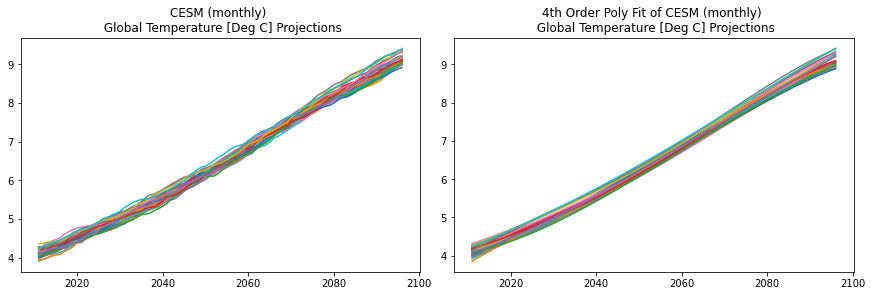

In [126]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True,figsize=(12,4))
for i in range(len(data.member_id)):
    ax[0].plot(data.time.dt.year,data.isel(member_id=i))
    ax[1].plot(fit.time.dt.year,fit.isel(member_id=i))
ax[0].set_title('CESM (monthly) \n Global Temperature [Deg C] Projections')
ax[1].set_title('4th Order Poly Fit of CESM (monthly) \n Global Temperature [Deg C] Projections')

In [127]:
# calculate internal variability uncertainity
internal = fit.var('member_id')

Text(0.5, 1.0, 'CESM1-LENS Internal Variability for \n Global Data via HS09')

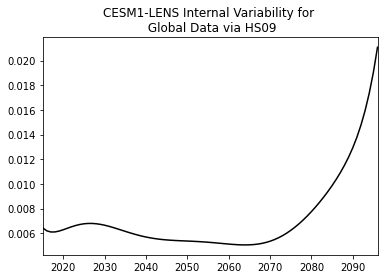

In [130]:
x = internal.time.dt.year
plt.plot(internal.time.dt.year,internal,color='k')
# plt.axhline(internal)
plt.xlim(x[4],x[-1])
plt.title('CESM1-LENS Internal Variability for \n Global Data via HS09')

In [131]:
data

<xarray.DataArray 'TREFHT' (time: 86, member_id: 40)>
array([[4.1472683, 4.2131457, 4.0952744, ..., 4.1147547, 4.3539796,
        4.2171936],
       [4.232961 , 4.2337494, 4.1417985, ..., 4.1884756, 4.3746834,
        4.287774 ],
       [4.2692184, 4.2699456, 4.2030616, ..., 4.267906 , 4.3908525,
        4.328128 ],
       ...,
       [9.092363 , 8.975054 , 8.937713 , ..., 9.302353 , 9.270027 ,
        9.272532 ],
       [9.1650505, 9.075559 , 9.027014 , ..., 9.346382 , 9.33789  ,
        9.356341 ],
       [9.200039 , 9.129929 , 9.09138  , ..., 9.382886 , 9.414165 ,
        9.397208 ]], dtype=float32)
Coordinates:
  * time       (time) object 2011-12-31 00:00:00 ... 2096-12-31 00:00:00
  * member_id  (member_id) int64 1 2 3 4 5 6 7 8 ... 34 35 101 102 103 104 105

In [132]:
# calculate internal via LE method 
internal = data.var('member_id')

Text(0.5, 1.0, 'CESM1-LENS Internal Variability for \n Global Data via LE Method')

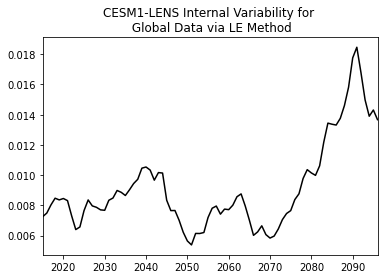

In [133]:
x = internal.time.dt.year
plt.plot(internal.time.dt.year,internal,color='k')
# plt.axhline(internal)
plt.xlim(x[4],x[-1])
plt.title('CESM1-LENS Internal Variability for \n Global Data via LE Method')